# Introduction to Time Series Forecasting

PyData NYC - April 10, 2024

Jorn Mossel, PhD

# Example of Time Series Models

* Classical (statistical) Models
    * [ARIMA (AutoRegressive Integrated Moving Average)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) 
    * [Exponential Smoohting (Holt-Winters)](https://en.wikipedia.org/wiki/Exponential_smoothing)
    * ...
* Machine Learning Models
    * Turn traditional ML models into time series models (eg Linear Regression, Boosted Trees)
* Deep Learning
    * [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (RNN architecture)
    * [PatchTST](https://arxiv.org/pdf/2211.14730.pdf) (Transformer based) - 2022
    * [N-HiTS](https://arxiv.org/abs/2201.12886) (MLP architecture optimized for time series) - 2022
    * [TiDE](https://arxiv.org/abs/2304.08424) (encoder-decoder) - 2023
    * ...
* Foundation Models
    * [TimeGPT (by NIXTLA)](https://docs.nixtla.io/) - 2023
    * [Chronos (by Amazon)](https://www.amazon.science/code-and-datasets/chronos-learning-the-language-of-time-series) - March 2024

# Overview Python Packages for Time Series Forecasting

* [NIXTLA](https://nixtlaverse.nixtla.io/)
* [GluonTS](https://ts.gluon.ai/stable/)
* [Darts](https://unit8co.github.io/darts/index.html)
* [SKTIME](https://www.sktime.net/en/stable/)

In [1]:
%%capture
!pip install statsforecast
!pip install neuralforecast

In [32]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2

import matplotlib.pyplot as plt
import pandas as pd
import os

from statsforecast import StatsForecast
from statsforecast.arima import arima_string
from statsforecast.models import MSTL, AutoARIMA, AutoETS
from statsforecast.utils import AirPassengersDF, ConformalIntervals

from utilsforecast.losses import mse, mape

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, LSTM, PatchTST, NBEATS

os.environ['NIXTLA_ID_AS_COL'] = '1'

env: PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2


# Example 1: Airline Passengers

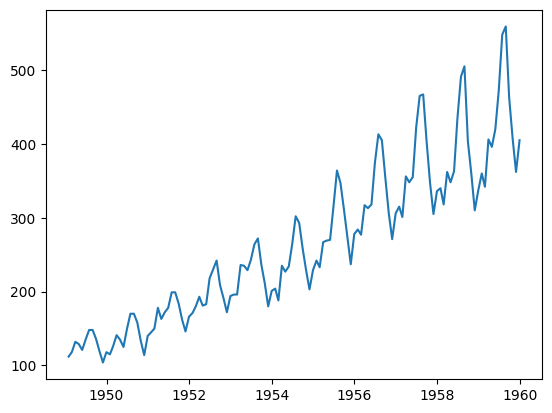

In [33]:
air_df = AirPassengersDF

air_train_df = air_df.iloc[:-12]
air_test_df = air_df.iloc[-12:]

plt.plot(air_train_df['ds'],air_train_df['y']);

# Trend Seasonal Decompostion
Time series can be decomposed in the following:
* Trend: $T(t)$
* Seasonal: $S(t)$
* Residuals: $R(t)$

Two different models:
* $y(t) = T(t) + S(t) + R(t)$ (additive)
* $y(t) = T(t) \times S(t) \times R(t)$ (multiplicative)


### Multiple Seasonal Trend (MSTL)

In [34]:
sf_trend_seasonal = StatsForecast(
    models = [MSTL(season_length=[12])], 
    freq='M', #monthly frequency
)
sf_trend_seasonal.fit(air_train_df)

StatsForecast(models=[MSTL])

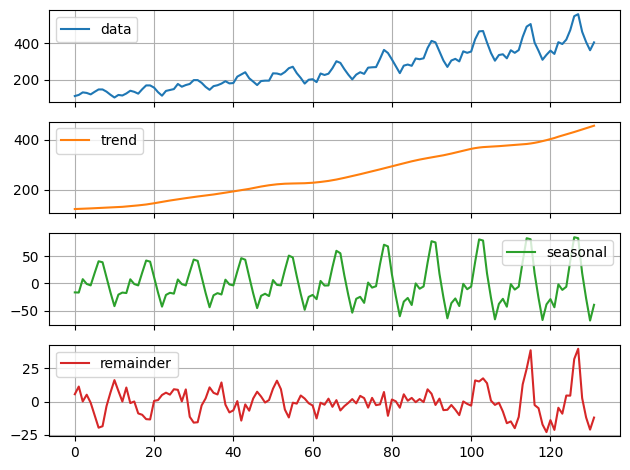

In [35]:
sf_trend_seasonal.fitted_[0, 0].model_.plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

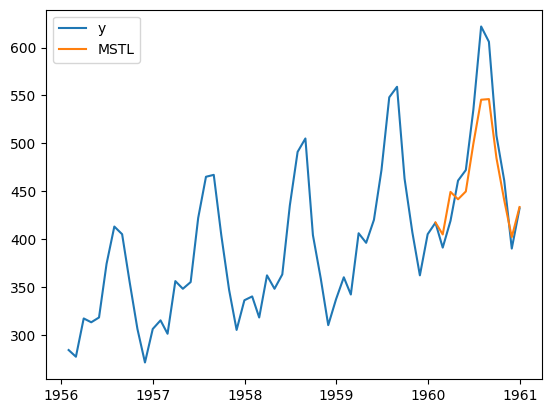

In [36]:
air_pred_df = sf_trend_seasonal.predict(h=12)

plt.plot(air_df['ds'].iloc[-60:],air_df['y'].iloc[-60:],label='y')
plt.plot(air_pred_df['ds'], air_pred_df['MSTL'],label='MSTL')
plt.legend()

# Classical Time Series Models (aka Statistical Models)

* ETS: Exponential Smoothing
* ARIMA: AutoRegressive Integrated Moving Average model - modeling (partial) autocorrelations

In [40]:
sf_classical = StatsForecast(
    models=[
        AutoARIMA(season_length = 12),
        AutoETS(season_length = 12, damped=True),     
        ],
    freq='M',
)

sf_classical.fit(air_train_df)

StatsForecast(models=[AutoARIMA,AutoETS])

In [8]:
arima_string(sf_classical.fitted_[0,0].model_)

'ARIMA(1,1,0)(0,1,0)[12]                   '

In [9]:
air_pred_classical_df = sf_classical.predict(h=12)

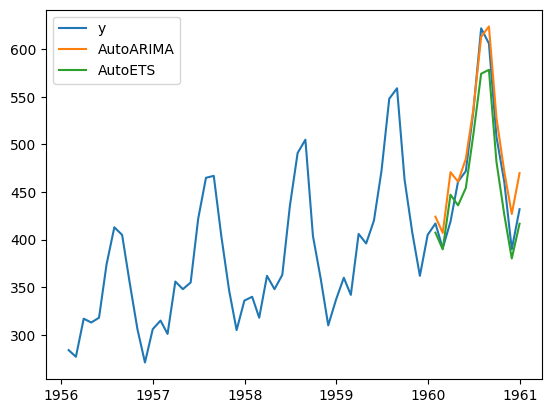

In [39]:
plt.plot(air_df['ds'].iloc[-60:],air_df['y'].iloc[-60:],label='y')
# plt.plot(air_pred_df['ds'], air_pred_df['MSTL'],label='MSTL')
plt.plot(air_pred_classical_df['ds'], air_pred_classical_df['AutoARIMA'],label='AutoARIMA')
plt.plot(air_pred_classical_df['ds'], air_pred_classical_df['AutoETS'],label='AutoETS')
plt.legend()

## Evaluate Predictions ###

**MSE (Mean Squared Error):**
    $$\text{mean}((\hat{y}_t - y_t)^2)$$
* Not scale independent

**MAPE (Mean Absolute Percentage Error)**
$$\text{mean}(|\frac{\hat{y}_t-y_t}{y_t}|)$$
* Scale independent
* Doesn't behave well for values close to zero

In [43]:
air_eval_classical_df = air_pred_classical_df.copy()
air_eval_classical_df['y'] = air_test_df['y'].values
air_eval_classical_df['MSTL'] = air_pred_df['MSTL'].values
# air_eval_classical_df['Ensemble'] = 0.5 * air_eval_classical_df['AutoARIMA'] +0.5* air_eval_classical_df['AutoETS']

mape(air_eval_classical_df,['AutoARIMA','AutoETS','MSTL'])

,unique_id,AutoARIMA,AutoETS,MSTL
0,1.0,0.041876,0.044994,0.050862


### Neural Network Models

* LSTM (RNN - Recurrent Neural Network)
* PatchTST (transformer)
* NHiTS (MLP)

In [44]:
horizon = 12
max_steps = 200

sf_neural = NeuralForecast(models=[
    LSTM(h=horizon, encoder_hidden_size=128, decoder_hidden_size=128, max_steps=max_steps),
    PatchTST(h=horizon, input_size=100, n_heads=4, hidden_size=16, max_steps=max_steps),
    NHITS(h=horizon, input_size=24, max_steps=max_steps),
], freq='M')

sf_neural.fit(air_train_df)
air_neural_df = sf_neural.predict()

Seed set to 1


Seed set to 1
Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

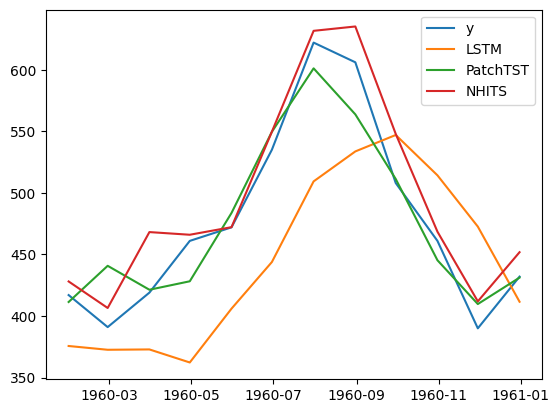

In [46]:
plt.plot(air_neural_df['ds'], air_neural_df['y'], label='y')
plt.plot(air_neural_df['ds'], air_neural_df['LSTM'], label='LSTM')
plt.plot(air_neural_df['ds'], air_neural_df['PatchTST'], label='PatchTST')
plt.plot(air_neural_df['ds'], air_neural_df['NHITS'], label='NHITS')
plt.legend()

In [47]:
air_neural_df['y'] = air_test_df['y'].values
mape(air_neural_df,['LSTM','PatchTST','NHITS'])

,unique_id,LSTM,PatchTST,NHITS
0,1.0,0.127713,0.038817,0.040174


# Probabilistic Forecasting 
Instead of a point estimate 

In [76]:
intervals = ConformalIntervals(h=12, n_windows=4)

sf_prob = StatsForecast(
    models=[AutoARIMA(season_length = 12, prediction_intervals=intervals)],
    freq='M',
)
sf_prob.fit(air_train_df)

StatsForecast(models=[AutoARIMA])

In [77]:
levels = [75, 95] # confidence levels of the prediction intervals 

forecasts = sf_prob.forecast(h=12, level=levels)

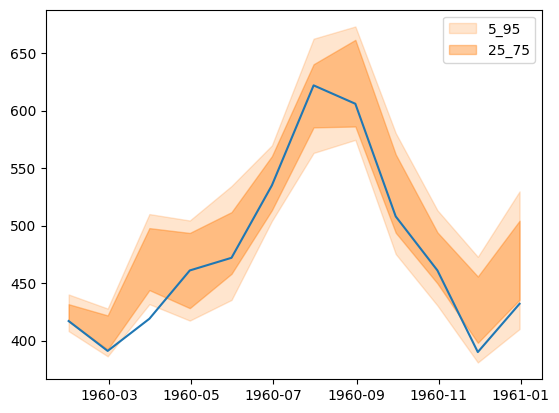

In [78]:
plt.fill_between(forecasts['ds'],forecasts['AutoARIMA-lo-95'],forecasts['AutoARIMA-hi-95'],alpha=0.20, color='tab:orange', label="5_95")
plt.fill_between(forecasts['ds'],forecasts['AutoARIMA-lo-75'],forecasts['AutoARIMA-hi-75'],alpha=0.40, color='tab:orange',label="25_75")
plt.plot(air_test_df['ds'], air_test_df['y'])
plt.legend()

# Example 2: Energy Price Forecasting (with covariates)

In [19]:
epf_df = pd.read_csv("https://raw.githubusercontent.com/jjmossel/time-series-tutorial/master/electricty_demand.csv", parse_dates=['ds'])

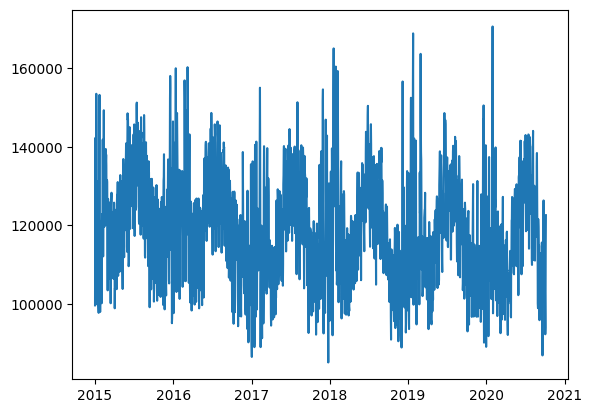

In [21]:
plt.plot(epf_df['ds'], epf_df['y'])

### Backtesting (Cross-Validation)

![backtest](https://raw.githubusercontent.com/jjmossel/time-series-tutorial/master/backtest.png)

In [22]:
epf_df1 = epf_df.copy()
epf_df1 = epf_df1[['unique_id','ds','y']]

In [66]:
horizon = 1 # day-ahead daily forecast
epf_models_1 = [NHITS(h = horizon,
                input_size = 7*horizon,
                max_steps = 500,
                early_stop_patience_steps=2,
                val_check_steps = 100,
                scaler_type = 'robust',
                enable_progress_bar=False,
                )]

epf_nf1 = NeuralForecast(models=epf_models_1, freq='D')

Seed set to 1


In [67]:
epf_bt1 = epf_nf1.cross_validation(epf_df1, n_windows=15, step_size=horizon, val_size=horizon, refit=3)

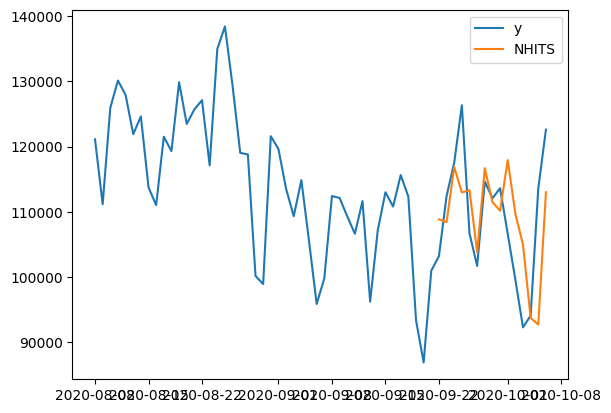

In [68]:
plt.plot(epf_df1['ds'].iloc[-60:],epf_df1['y'].iloc[-60:],label='y')
plt.plot(epf_bt1['ds'],epf_bt1['NHITS'],label='NHITS')
plt.legend()

## Extend the Model with Covariates (Temperature variables)

Text(0, 0.5, 'demand')

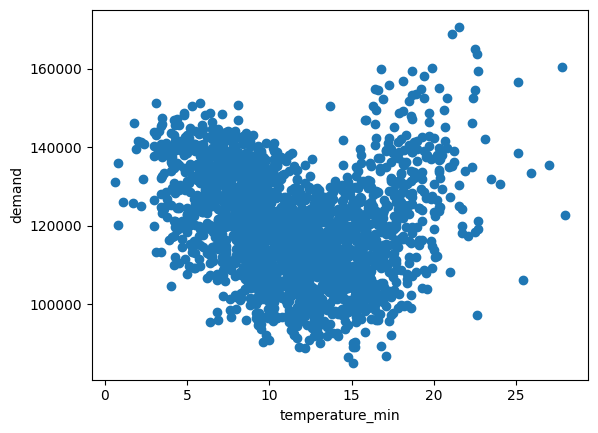

In [25]:
plt.scatter(epf_df['temperature_min'], epf_df['y'])
plt.xlabel('temperature_min')
plt.ylabel('demand');

In [26]:
epf_df2 = epf_df.copy()
epf_df2 = epf_df2[['unique_id','ds','y','temperature_min' ,'temperature_max','is_weekday']]

In [69]:
epf_models_2 = [NHITS(h = horizon,
                input_size = 7*horizon,
                futr_exog_list = ['temperature_min' ,'temperature_max','is_weekday'], # <- Future exogenous variables
                max_steps = 500,
                early_stop_patience_steps=2,
                val_check_steps = 100,
                scaler_type = 'robust',
                enable_progress_bar = False
                )]

epf_nf2 = NeuralForecast(models=epf_models_2, freq='D')

Seed set to 1


In [70]:
epf_bt2  = epf_nf2.cross_validation(epf_df2, n_windows=15, step_size=horizon, val_size=horizon, refit=3)

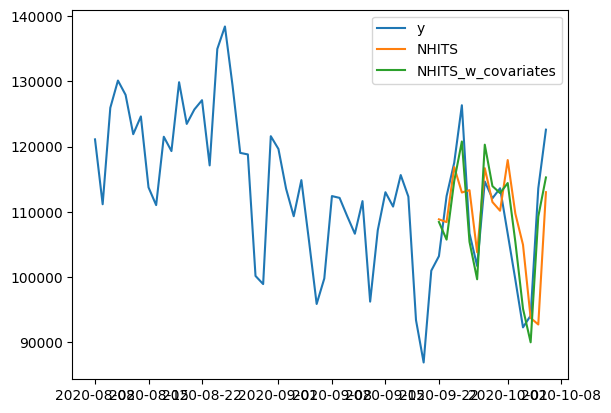

In [71]:
plt.plot(epf_df1['ds'].iloc[-60:],epf_df1['y'].iloc[-60:],label='y')
plt.plot(epf_bt1['ds'],epf_bt1['NHITS'],label='NHITS')
plt.plot(epf_bt2['ds'],epf_bt2['NHITS'],label='NHITS_w_covariates')
plt.legend()

In [72]:
mape(epf_bt1 ,['NHITS']), mape(epf_bt2,['NHITS'])

(  unique_id     NHITS
 0  Victoria  0.063249,
   unique_id     NHITS
 0  Victoria  0.039091)